# Explore the Governance Data Set

This notebook explores the Governence documents data set. We experiment with extraction from various forms of input document, word clouds to get a sense of word frequency and of course machine learning algorithms.

* Import Corné's python script
* GM0007CA01.zip contains a link instead of the text
* invetigate empty files that do have text in the source
* investigate oddly short files

---
## Installation and Dependencies
Here we install dependencies.

For text extraction from the Word documents we use [Antiword](https://pypi.org/project/antiword/), a text extraction front-end to Libreoffice. Your Notebook server should have [Libreoffice](https://www.libreoffice.org/) installed.

In [ ]:
!pip install pymupdf filetype textract antiword wordcloud scikit-learn pandas beautifulsoup4

In [1]:
import re
import sys
import hashlib
from pathlib import Path
WRITE='w'
READ_BINARY='rb'
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import fitz
print(fitz.__doc__)
# print(f"pymupdf=={fitz.__version__}")

import filetype
print(f"filetype=={filetype.__version__}")

import textract

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
print(f"nltk=={nltk.__version__}")

from bs4 import BeautifulSoup
from bs4 import __version__ as bs4__version__
print(f"beautifulsoup4=={bs4__version__}")

import chardet
print(f"chardet=={chardet.__version__}")


python==3.10.9

PyMuPDF 1.22.3: Python bindings for the MuPDF 1.22.0 library.
Version date: 2023-05-10 00:00:01.
Built for Python 3.10 on linux (64-bit).

filetype==1.2.0
wordcloud==1.9.2
scikit-learn==1.2.2
pandas==2.0.1
matplotlib==3.7.1
nltk==3.8.1
beautifulsoup4==4.8.2
chardet==3.0.4


---
## Structure of the Data
As this is a project with unstructured data, we should preserve what little structure there is. The raw data comes as hand written documents from many authors, though the file names are meaningful. This section documents the data structure that we use on disk in this project and defines Python constants and a few [file name globs](https://realpython.com/get-all-files-in-directory-python/#using-a-python-glob-pattern-for-conditional-listing) to make document handling easier.

### Directory Structure
The raw data set is *not* in GIT, simply because of the file size. You can ask the project team for the original data set. The raw data files are stored in `executing-enexis/data/Governance/GM*.*` (known as `GLOB_RAW_DOCUMENTS` in Python code). Extracted text and document artifacts can be found under `executing-enexis/cache/Governance/` (`DATA_DIR` in Python).

### File Name Structure
The file names to the documents are fixed-length records with the following meaning: `"GM"<gemeente code (4-positions)><document type (2 positions)><id number (2 positions>"."<extension>`.

The gemeente code can be mapped with the codes in `XXX`.

The two-character document type can be found in the table below. Each document type has a glob for quick access to all documents of that type. These globs can be found in the same table, although you may find the mapping intuitive.

| Document Type ID | Document Type             | Pathlib Glob   |
|------------------|---------------------------|----------------
| CA               | Coalitieakkoord           | `GLOB_CA`      |
| DV               | Duurzaamheidsprogramma    | `GLOB_DV`      |
| EX               | Externe documenten        | `GLOB_EX`      |
| IK               | Inkoopbeleid              | `GLOB_IK`      |
| JS               | Jaarstukken               | `GLOB_JS`      |
| OB               | Overige beleidsdocumenten | `GLOB_OB`      |
| PB               | Programmabegroting        | `GLOB_PB`      |
| TV               | Toekomstvise              | `GLOB_TV`      |
| WS               | Website gemeente          | `GLOB_WS`      |

The file extension is not completely reliable. Especially documents with extension `.zip` seem not to be of mime type `application/zip`, but rather of type `text/html`. More on that in the text extraction, below.

In [2]:
# take any path and map it from the data directory to the cache directory.
def to_cache(path):
    return Path(str(path).replace('/data/', '/cache/'))

DATA_DIR = Path('../data/Governance').resolve()
CACHE_DIR = to_cache(DATA_DIR)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# The raw documents, warts and all; PDFs, ZIP files and Word documents.
GLOB_RAW_DOCUMENTS = str(DATA_DIR) + '/GM????????.*'

# The files containing the extracted text from the raw documents.
GLOB_ALL_DOCUMENTS = str(CACHE_DIR) + '/GM????????.txt'

GLOB_CA = str(CACHE_DIR) + '/GM????CA??.txt'
GLOB_DV = str(CACHE_DIR) + '/GM????DV??.txt'
GLOB_EX = str(CACHE_DIR) + '/GM????EX??.txt'
GLOB_IK = str(CACHE_DIR) + '/GM????IK??.txt'
GLOB_JS = str(CACHE_DIR) + '/GM????JS??.txt'
GLOB_OB = str(CACHE_DIR) + '/GM????OB??.txt'
GLOB_PB = str(CACHE_DIR) + '/GM????PB??.txt'
GLOB_TV = str(CACHE_DIR) + '/GM????TV??.txt'
GLOB_WS = str(CACHE_DIR) + '/GM????WS??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"raw documents: {GLOB_RAW_DOCUMENTS}")
print(f"extracted documents = {GLOB_ALL_DOCUMENTS}")


raw documents: /home/jovyan/jads/execute-enexis/data/Governance/GM????????.*
extracted documents = /home/jovyan/jads/execute-enexis/cache/Governance/GM????????.txt


---
## Text Extraction
This section extracts the text from the raw documents. It deals with the file formats and file encodings. Text extraction from Word files is done with Antiword and Libreoffice. For the PDFs we use [PyMuPDF](https://pypi.org/project/PyMuPDF/) instead. Antiword's development seems to have stagnated, so we only use it where we have to. HTML is cleaned up using [Beautiful Soup](https://pypi.org/project/beautifulsoup4/).

As usual there are a few document oddities to contend with: a mix of file encodings, some documents are empty and some have the wrong [MIME type](https://en.wikipedia.org/wiki/Media_type#Mime.types). For example, documents with extension `.zip` seem not to be of MIME type `application/zip`, but rather of type `text/html`. Some of these `.zip` files are empty as well. There is one text document that contains CSS, so we exclude that specific file.

For tokenization we chose quite a limited set of acceptable characters: only alphabetic characters and a few [accented characters](https://nl.wikipedia.org/wiki/Accenttekens_in_de_Nederlandse_spelling) that are common in the Dutch language. Early experiments showed that a lot of numerical "words" would creep into the data. That makes sense as many of these documents talk about finance, but hinders finding meaning. Numbers really only make sense in context and we simply don't have the context. By stripping out the numbers we also stripped the years out of the text, which do have meaning out of context. We chose to leave these out.

The text extraction also performs some light preprocessing on the text, such as [stop word removal](https://en.wikipedia.org/wiki/Stop_word) and [stemming](https://en.wikipedia.org/wiki/Stemming), taking care to use the Dutch form of each of these. These are fairly slow operations, so they combine well with the extract-and-cache step of the process. That said, we should not preprocess too much, lest we subtly change the meaning of the text.

Due to the nature, number and size of the raw documents, text extraction takes quite a bit of time. To speed up iterating over the data set we cache the resultant files in `CACHE_DIR` for quick access. These can then be accessed using the globs defined earlier.





 


In [3]:
# The stopwords for the Dutch language. These come as downloadable sets with NLTK.
nltk.download('stopwords')
nltk.download('punkt')
dutch_stopwords = set(stopwords.words('dutch'))

# The stemming utility, also for the Dutch language.
dutch_stemmer = SnowballStemmer('dutch')


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def stemmed_tokens(text, stemmer):
    return [stemmer.stem(token.strip().lower()) for token in re.split('[^a-zA-Zëéèïöóà]+', text)]

def cleaned_and_stemmed_text(text, stopwords, stemmer):
    return ' '.join([token for token in stemmed_tokens(text, stemmer) if (token not in stopwords) and (len(token) > 2)])

def extract_pdf(from_file, to_file, stopwords, stemmer):
    document = fitz.open(from_file)
    with open(to_file, WRITE) as f:
        for page in document:
            text = page.get_text('text')
            text = cleaned_and_stemmed_text(text, stopwords, stemmer)
            f.write(text)
            f.write('\n')

def extract_msword(from_file, to_file, stopwords, stemmer):
    with open(to_file, WRITE) as f:
        text = str(textract.process(str(from_file)))
        text = cleaned_and_stemmed_text(text, stopwords, stemmer)
        f.write(text)

def encoding_of(file):
    rawdata = open(file, "rb").read()
    if len(rawdata) == 0:
        return 'ascii'
    encoding = chardet.detect(rawdata)['encoding']
    print(f"loading {file} using {encoding} encoding")
    return encoding

def extract_plain(from_file, to_file, stopwords, stemmer):
    text = from_file.read_text(encoding=encoding_of(from_file))
    if len(text) == 0:
        print(f"ignoring {from_file} as it is empty")
    else:
        with open(to_file, WRITE) as f:
            text = cleaned_and_stemmed_text(text, stopwords, stemmer)
            f.write(text)

# https://stackoverflow.com/questions/328356/extracting-text-from-html-file-using-python

def extract_html(from_file, to_file, stopwords, stemmer):
    text = from_file.read_text(encoding=encoding_of(from_file))
    if len(text) == 0:
        print(f"ignoring {from_file} as it is empty")
    else:
        with open(to_file, WRITE) as f:
            soup = BeautifulSoup(text, features="html.parser")
            # r=ip out script and style elements as these would pollute the text
            for script in soup(["script", "style"]):
                script.extract()
            text = soup.get_text()
            
            text = cleaned_and_stemmed_text(text, stopwords, stemmer)
            f.write(text)

def extract_dir(glob, stopwords, stemmer):
    skipped = 0
    for from_file in expand_glob(glob):
        mime_type = filetype.guess_mime(from_file)
        to_file = to_cache(from_file.with_suffix('.txt'))

        if to_file.exists():
            skipped += 1
        elif from_file.stem == 'GM1711OB02':
            print(f"ignoring {from_file} as it is of MIME type text/css")
        elif mime_type == "application/pdf":
            extract_pdf(from_file, to_file, stopwords, stemmer)
        elif mime_type == "application/vnd.openxmlformats-officedocument.wordprocessingml.document" or \
             mime_type == "application/msword":
            extract_msword(from_file, to_file, stopwords, stemmer)
        elif not mime_type:
            if from_file.suffix.lower() == '.txt':
                extract_plain(from_file, to_file, stopwords, stemmer)
            if from_file.suffix.lower() == '.zip':
                # seems wrong, but it is correct for our data...
                extract_html(from_file, to_file, stopwords, stemmer)
        else:
            raise Exception(f"don't known how to handle {from_file} of MIME type {mime_type}")
    print(f"skipped {skipped} files that have previously been extracted")

In [5]:
extract_dir(GLOB_RAW_DOCUMENTS, dutch_stopwords, dutch_stemmer)

ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM0147PB02.zip as it is empty
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM0225OB02.zip as it is empty
loading /home/jovyan/jads/execute-enexis/data/Governance/GM0399PB03.zip using ascii encoding
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM0439CA02.zip as it is empty
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM0439CA03.zip as it is empty
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM0542CA01.zip as it is empty
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM0613OB02.zip as it is empty
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM0772IK02.zip as it is empty
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM1680DV01.zip as it is empty
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM1711OB02.txt as it is of MIME type text/css
ignoring /home/jovyan/jads/execute-enexis/data/Governance/GM1916TV02.zip as it is empty
skipped 227

### Deduplication
The data set was assembled by a group of people answering a questionnaire and uploading document supporting their arguments in the process. Sometimes they would upload the same document to answer more than one question on the questionnaire, so we have a few duplicate files. Here we identify duplicates by checksum and remove their cached text documents.


In [6]:
# https://stackoverflow.com/questions/3431825/generating-an-md5-checksum-of-a-file

def md5(file):
    hash_md5 = hashlib.md5()
    with open(file, READ_BINARY) as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def delete_duplicates(glob):
    hashes = set()
    dupes = 0
    for file in expand_glob(glob):
        hash = md5(file)
        if hash in hashes:
            print(f"deleting {file} as dupe")
            file.unlink()
            dupes += 1
        else:
            hashes.add(hash)
    print(f"deleted {dupes} duplicates")

In [7]:
delete_duplicates(GLOB_ALL_DOCUMENTS)

deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0063CA03.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0079EX01.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0079IK01.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0147CA03.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0148OB02.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0173IK01.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0293IK01.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0302OB01.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0302TV01.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0310CA01.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0327DV03.txt as dupe
deleting /home/jovyan/jads/execute-enexis/cache/Governance/GM0375CA01.txt as dupe
deleting /home/j

---
## Generate Word Clouds
We now go through the text documents again, and generate a word cloud image for each file. There are too many to show word clouds for individual files, so we don't try. We do generate and show the word clouds for a few of the collections of documents.

In [8]:
def make_per_file_cloud(glob):
    for file in expand_glob(glob):
        try:
            cloud = WordCloud(background_color="white", max_words=20).generate(file.read_text())
            cloud.to_file(file.with_suffix('.png'))
        except ValueError as e:
            print(f"cannot generate word cloud for {file}: {e}")


In [9]:
make_per_file_cloud(GLOB_ALL_DOCUMENTS)

cannot generate word cloud for /home/jovyan/jads/execute-enexis/cache/Governance/GM0005CA01.txt: We need at least 1 word to plot a word cloud, got 0.
cannot generate word cloud for /home/jovyan/jads/execute-enexis/cache/Governance/GM0014OB04.txt: We need at least 1 word to plot a word cloud, got 0.
cannot generate word cloud for /home/jovyan/jads/execute-enexis/cache/Governance/GM0056CA01.txt: We need at least 1 word to plot a word cloud, got 0.
cannot generate word cloud for /home/jovyan/jads/execute-enexis/cache/Governance/GM0063JS01.txt: We need at least 1 word to plot a word cloud, got 0.
cannot generate word cloud for /home/jovyan/jads/execute-enexis/cache/Governance/GM0085IK01.txt: We need at least 1 word to plot a word cloud, got 0.
cannot generate word cloud for /home/jovyan/jads/execute-enexis/cache/Governance/GM0140IK01.txt: We need at least 1 word to plot a word cloud, got 0.
cannot generate word cloud for /home/jovyan/jads/execute-enexis/cache/Governance/GM0147CA02.txt: We 

In [10]:
def make_word_cloud(glob):
    corpus = ""
    for file in expand_glob(glob):
        corpus = corpus + " " + file.read_text()

    cloud = WordCloud(background_color="white", max_words=50).generate(corpus)
    plt.axis('off')
    plt.imshow(cloud);


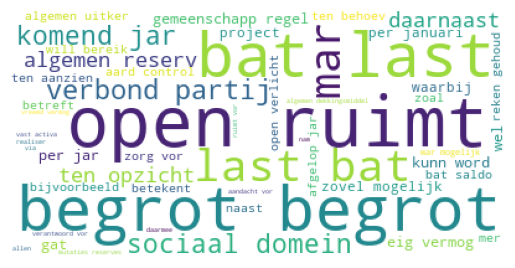

In [11]:
make_word_cloud(GLOB_ALL_DOCUMENTS)


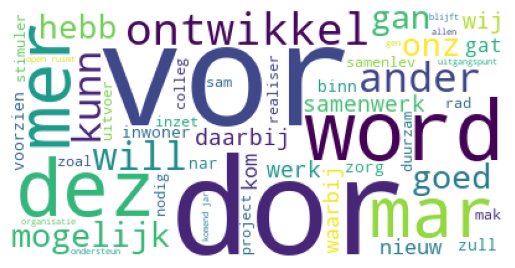

In [12]:
make_word_cloud(GLOB_CA)


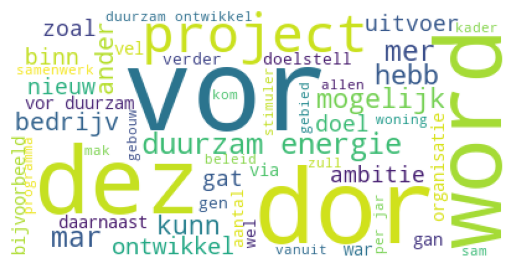

In [13]:
make_word_cloud(GLOB_DV)


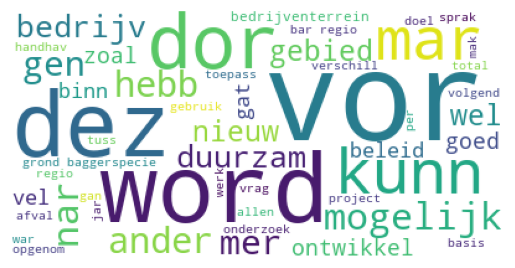

In [14]:
make_word_cloud(GLOB_EX)


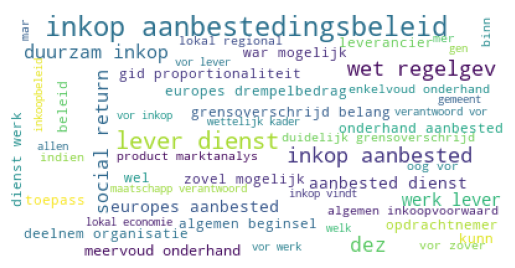

In [15]:
make_word_cloud(GLOB_IK)


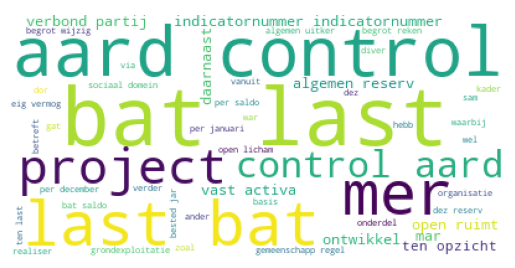

In [16]:
make_word_cloud(GLOB_JS)


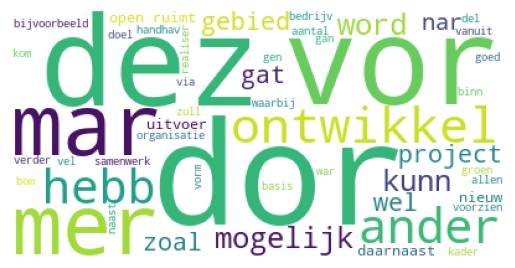

In [17]:
make_word_cloud(GLOB_OB)


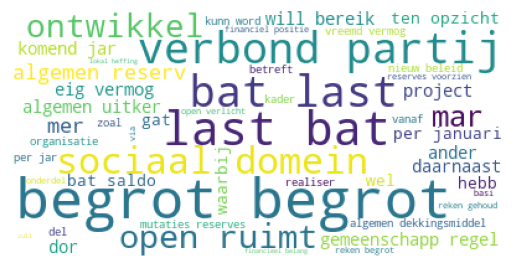

In [18]:
make_word_cloud(GLOB_PB)


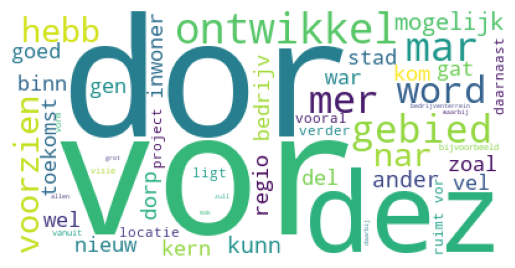

In [19]:
make_word_cloud(GLOB_TV)


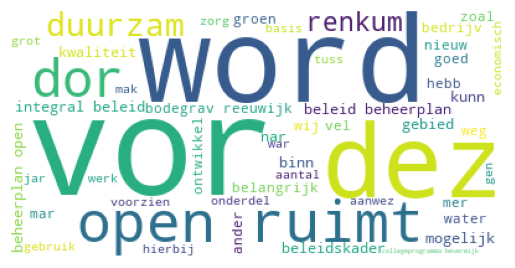

In [20]:
make_word_cloud(GLOB_WS)
